AirBnB Project
---



##Body

###Imports

In [11]:
%matplotlib inline

!pip install bayesian-optimization

##Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##Data-wrangling tools
import pandas_profiling
from sklearn.compose import ColumnTransformer
import datetime as dt
from datetime import datetime

##Modeling
import gzip
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import pickle
import xgboost as xgb
from bayes_opt import BayesianOptimization

###Dataframe creation

In [0]:
detailed_listing = 'http://data.insideairbnb.com/united-states/ca/los-angeles/2019-12-05/data/listings.csv.gz'

det_list = pd.read_csv(detailed_listing, compression='gzip', 
                       error_bad_lines=False, warn_bad_lines=False)

print(det_list.shape)
det_list.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(40125, 106)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,109,https://www.airbnb.com/rooms/109,20191205175409,2019-12-06,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...","*** Unit upgraded with new bamboo flooring, br...","*** Unit upgraded with new bamboo flooring, br...",none,NaN,NaN,NaN,NaN,NaN,Camelot NEW RESIDENTS’ GENERAL INFORMATION F...,NaN,NaN,https://a0.muscache.com/im/pictures/4321499/1d...,NaN,521,https://www.airbnb.com/users/show/521,Paolo,2008-06-27,"San Francisco, California, United States",Search for me on the Internet with the keyword...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/521/profile_p...,https://a0.muscache.com/im/users/521/profile_p...,Culver City,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Culver City, CA, United States",Culver City,Culver City,...,$25.00,30,730,30,30,730,730,30.0,730.0,10 months ago,t,0,0,0,248,2019-12-06,2,0,2011-08-15,2016-05-15,80.0,10.0,10.0,6.0,8.0,10.0,8.0,f,NaN,"{""Culver City"","" CA""}",f,f,strict_14_with_grace_period,t,f,1,1,0,0,0.02
1,344,https://www.airbnb.com/rooms/344,20191205175409,2019-12-06,Family perfect;Pool;Near Studios!,This home is perfect for families; aspiring ch...,"Cheerful & comfortable; near studios, amusemen...",This home is perfect for families; aspiring ch...,none,Quiet-yet-close to all the fun in LA! Hollywoo...,"One dog may be on premises, friendly and cared...",Short drive to subway and elevated trains runn...,"Pool, patio and self-contained main house all ...",Host and caretaker may be available throughout...,Host asks that guests refrain from partying lo...,NaN,NaN,https://a0.muscache.com/im/pictures/cc4b724d-d...,NaN,767,https://www.airbnb.com/users/show/767,Melissa,2008-07-11,"Burbank, California, United States","Single mother, CEO and Owner of an internation...",within a few hours,100%,NaN,f,https://a0.muscache.com/im/users/767/profile_p...,https://a0.muscache.com/im/users/767/profile_p...,Burbank,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'kba', ...",t,t,"Burbank, CA, United States",Burbank,Burbank,...,$0.00,2,14,2,2,14,14,2.0,14.0,2 months ago,t,0,0,0,62,2019-12-06,8,2,2016-06-14,2019-10-19,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,t,f,flexible,f,f,1,1,0,0,0.19
2,2708,https://www.airbnb.com/rooms/2708,20191205175409,2019-12-06,Mirrored Mini-Suite with Fireplace - W. Hollywood,Our best memory foam pillows you'll ever sleep...,Flickering fireplace. Blendtec® Designer 625 ...,Our best memory foam pillows you'll ever sleep...,none,We are minutes away from the Mentor Language I...,Blendtec® Designer 625 

In [0]:
calendar_url = 'http://data.insideairbnb.com/united-states/ca/los-angeles/2019-12-05/data/calendar.csv.gz'

calendar_df = pd.read_csv(calendar_url, compression='gzip', 
                          warn_bad_lines=False, error_bad_lines=False)

print(calendar_df.shape)
calendar_df.head()

(14670849, 7)


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,46858,2019-12-06,f,$300.00,$300.00,3.0,30.0
1,130915,2019-12-06,f,$90.00,$90.00,1.0,730.0
2,130915,2019-12-07,f,$90.00,$90.00,1.0,730.0
3,130915,2019-12-08,f,$90.00,$90.00,1.0,730.0
4,130915,2019-12-09,f,$90.00,$90.00,1.0,730.0


In [0]:
#Wrangle calendar prices dataset

calendar_df['date'] = pd.to_datetime(calendar_df['date'])

calendar_df['weekday'] = calendar_df['date'].dt.dayofweek

calendar_df['month'] = calendar_df['date'].dt.month

calendar_df['price'] = calendar_df['price'].str.replace('$','')
calendar_df['price'] = calendar_df['price'].str.replace(',','')
calendar_df['price'] = calendar_df['price'].replace('',np.nan)

calendar_df['price'] = calendar_df['price'].astype(float)

calendar_df = calendar_df[['listing_id', 'price', 'month', 'weekday']]

calendar_df.head()

,listing_id,price,month,weekday
0,46858,300.0,12,4
1,130915,90.0,12,4
2,130915,90.0,12,5
3,130915,90.0,12,6
4,130915,90.0,12,0


In [0]:
#Wrangle detailed listings dataset

det_list['security_deposit'] = det_list['security_deposit'].str.replace('$','')
det_list['security_deposit'] = det_list['security_deposit'].str.replace(',','')
det_list['security_deposit'] = det_list['security_deposit'].replace('',np.nan).astype(float)

det_list['zipcode'] = det_list['zipcode'].str.strip()
det_list['zipcode'] = det_list['zipcode'].str.replace('ca','')
det_list['zipcode'] = det_list['zipcode'].str.replace('Ca','')
det_list['zipcode'] = det_list['zipcode'].str.replace('CA','')
det_list['zipcode'] = det_list['zipcode'].str.replace(' ', '')
det_list['zipcode'] = det_list['zipcode'].str.replace('139SValenciaAve,Glendora.', '')
det_list['zipcode'] = det_list['zipcode'].str[:5]
det_list['zipcode'] = det_list['zipcode'].replace('',np.nan)

det_list['beds'] = det_list['beds'].fillna(det_list['beds'].mode()[0]).astype(int)
det_list['bathrooms'] = det_list['bathrooms'].fillna(det_list['bathrooms'].median()).astype(int)
det_list['bedrooms'] = det_list['bedrooms'].fillna(det_list['bedrooms'].median()).astype(int)

det_list['amenities'] = det_list['amenities'].str.replace('"', '')

amenities_list = ['TV', 'Wifi', 'Kitchen', 'Air conditioning', 'Pool', 
                  'Hot tub', 'Washer', 'Dryer', 'Regrigerator', 'Iron', 
                  'Free parking on premises', 'Dishes and silverware', 
                  'Microwave']

def create_bool_from_dict(df, seriesdict, feature):
    df[feature] = df[seriesdict].str.contains(feature)
    return df[feature]

for x in amenities_list:
    create_bool_from_dict(det_list, 'amenities', x)

cols = ['id', 'cleaning_fee', 'bathrooms', 'bedrooms', 'guests_included',
        'zipcode', 'property_type', 'accommodates', 'beds', 'room_type', 
        'security_deposit'] + amenities_list

det_list = det_list[cols]

renamer = dict(zip(amenities_list, bool_features))
det_list = det_list.rename(columns=renamer)

det_list.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,TV,Wifi,Kitchen,Air conditioning,Pool,Hot tub,Washer,Dryer,Regrigerator,Iron,Free parking on premises,Dishes and silverware,Microwave
0,109,https://www.airbnb.com/rooms/109,20191205175409,2019-12-06,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...","*** Unit upgraded with new bamboo flooring, br...","*** Unit upgraded with new bamboo flooring, br...",none,NaN,NaN,NaN,NaN,NaN,Camelot NEW RESIDENTS’ GENERAL INFORMATION F...,NaN,NaN,https://a0.muscache.com/im/pictures/4321499/1d...,NaN,521,https://www.airbnb.com/users/show/521,Paolo,2008-06-27,"San Francisco, California, United States",Search for me on the Internet with the keyword...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/521/profile_p...,https://a0.muscache.com/im/users/521/profile_p...,Culver City,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Culver City, CA, United States",Culver City,Culver City,...,0,248,2019-12-06,2,0,2011-08-15,2016-05-15,80.0,10.0,10.0,6.0,8.0,10.0,8.0,f,NaN,"{""Culver City"","" CA""}",f,f,strict_14_with_grace_period,t,f,1,1,0,0,0.02,True,True,True,True,True,True,True,True,False,True,True,False,False
1,344,https://www.airbnb.com/rooms/344,20191205175409,2019-12-06,Family perfect;Pool;Near Studios!,This home is perfect for families; aspiring ch...,"Cheerful & comfortable; near studios, amusemen...",This home is perfect for families; aspiring ch...,none,Quiet-yet-close to all the fun in LA! Hollywoo...,"One dog may be on premises, friendly and cared...",Short drive to subway and elevated trains runn...,"Pool, patio and self-contained main house all ...",Host and caretaker may be available throughout...,Host asks that guests refrain from partying lo...,NaN,NaN,https://a0.muscache.com/im/pictures/cc4b724d-d...,NaN,767,https://www.airbnb.com/users/show/767,Melissa,2008-07-11,"Burbank, California, United States","Single mother, CEO and Owner of an internation...",within a few hours,100%,NaN,f,https://a0.muscache.com/im/users/767/profile_p...,https://a0.muscache.com/im/users/767/profile_p...,Burbank,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'kba', ...",t,t,"Burbank, CA, United States",Burbank,Burbank,...,0,62,2019-12-06,8,2,2016-06-14,2019-10-19,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,t,f,flexible,f,f,1,1,0,0,0.19,True,True,True,True,True,False,True,True,False,True,False,True,True
2,2708,https://www.airbnb.com/rooms/2708,20191205175409,2019-12-06,Mirrored Mini-Suite with Fireplace - W. Hollywood,Our best memory foam pillows you'll ever sleep...,Flickering fireplace. Blendtec® Designer 625 ...,Our best memory foam pillows you'll ever sleep...,none,We are minutes away from the Mentor Language I...,Blendtec® Designer 625 Blender Bundle with Twi...,There are many buses; bus stops going in every...,"Kitchen

In [0]:
#pandas_profiling.ProfileReport(det_list)

In [0]:
merged_calendar_detailed = pd.merge(det_list[cols], 
                                    calendar_df, how='left', 
                                    left_on='id', right_on='listing_id')

del det_list
del calendar_df

print(merged_calendar_detailed.shape)
merged_calendar_detailed.head()

(14647852, 28)


,id,cleaning_fee,bathrooms,bedrooms,guests_included,zipcode,property_type,accommodates,beds,room_type,security_deposit,TV,Wifi,Kitchen,Air conditioning,Pool,Hot tub,Washer,Dryer,Regrigerator,Iron,Free parking on premises,Dishes and silverware,Microwave,listing_id,price,month,weekday
0,109,$240.00,2,2,3,90230,Condominium,6,3,Entire home/apt,500.0,True,True,True,True,True,True,True,True,False,True,True,False,False,109,115.0,12,4
1,109,$240.00,2,2,3,90230,Condominium,6,3,Entire home/apt,500.0,True,True,True,True,True,True,True,True,False,True,True,False,False,109,115.0,12,5
2,109,$240.00,2,2,3,90230,Condominium,6,3,Entire home/apt,500.0,True,True,True,True,True,True,True,True,False,True,True,False,False,109,115.0,12,6
3,109,$240.00,2,2,3,90230,Condominium,6,3,Entire home/apt,500.0,True,True,True,True,True,True,True,True,False,True,True,False,False,109,115.0,12,0
4,109,$240.00,2,2,3,90230,Condominium,6,3,Entire home/apt,500.0,True,True,True,True,True,True,True,True,False,True,True,False,False,109,115.0,12,1


In [0]:
train = merged_calendar_detailed.drop(columns= ['listing_id','id'])

train = train[(train['price'].isna() == False) & (train['price']<10000)]

top_100_zipcodes = list(train['zipcode'].value_counts()[:100].index)
train['zipcode_recode'] = np.where(train['zipcode'].isin(top_100_zipcodes),
                                         train['zipcode'], 'other')

top_15_property_types = list(train['property_type'].value_counts()[:15].index)
train['property_type_recoded'] = np.where(train['property_type'].isin(top_15_property_types),
                                  train['property_type'], 'other')

train['cleaning_fee'] = train['cleaning_fee'].str.replace('$','')
train['cleaning_fee'] = train['cleaning_fee'].str.replace(',','')
train['cleaning_fee'] = train['cleaning_fee'].replace('',np.nan).astype(float)

for ii in amenities_list:
  train[ii] = np.where(train[ii] == True, 1, 0)
  train[ii] = train[ii].astype(int)

train = train.drop(columns= ['zipcode','property_type'])

train.head()

,cleaning_fee,bathrooms,bedrooms,guests_included,zipcode,property_type,accommodates,beds,room_type,security_deposit,TV,Wifi,Kitchen,Air conditioning,Pool,Hot tub,Washer,Dryer,Regrigerator,Iron,Free parking on premises,Dishes and silverware,Microwave,price,month,weekday,zipcode_recode,property_type_recoded
0,240.0,2,2,3,90230,Condominium,6,3,Entire home/apt,500.0,1,1,1,1,1,1,1,1,0,1,1,0,0,115.0,12,4,90230,Condominium
1,240.0,2,2,3,90230,Condominium,6,3,Entire home/apt,500.0,1,1,1,1,1,1,1,1,0,1,1,0,0,115.0,12,5,90230,Condominium
2,240.0,2,2,3,90230,Condominium,6,3,Entire home/apt,500.0,1,1,1,1,1,1,1,1,0,1,1,0,0,115.0,12,6,90230,Condominium
3,240.0,2,2,3,90230,Condominium,6,3,Entire home/apt,500.0,1,1,1,1,1,1,1,1,0,1,1,0,0,115.0,12,0,90230,Condominium
4,240.0,2,2,3,90230,Condominium,6,3,Entire home/apt,500.0,1,1,1,1,1,1,1,1,0,1,1,0,0,115.0,12,1,90230,Condominium


In [0]:
train.to_csv('merged_cleaned_nonencoded.csv')

###Checkpoint - saved dataframe can be loaded

In [2]:
train = pd.read_csv('merged_cleaned_nonencoded.csv.gz', compression = 'gzip', index_col=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


next will do a linear regression model for a baseline

In [3]:
# Features we want
train = train.drop(columns=['zipcode_recode'])

categorical_features = list(train.select_dtypes(exclude= 'number').columns)

numeric_features = list(train.select_dtypes(include= 'number').columns)

categorical_features

['room_type', 'property_type_recoded']

In [0]:
# We'll impute missing values using the median for numeric columns and the most
# common value for string columns.

from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

train = DataFrameImputer().fit_transform(train)

In [5]:
##Encode categorical features

# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()

# for feature in categorical_features:
#     train[feature] = label_encoder.fit_transform(train[feature])

for feature in categorical_features:
    train = pd.concat([train,pd.get_dummies(train[feature], prefix=feature)],
                        axis=1).drop([feature], axis=1)

print(train.shape)
train.head()

(14633653, 43)


,cleaning_fee,bathrooms,bedrooms,guests_included,accommodates,beds,security_deposit,tv,wifi,kitchen,air_conditioning,pool,hot_tub,washer,dryer,refrigerator,iron,free_parking,dishes_and_silverware,microwave,price,month,weekday,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,property_type_recoded_Apartment,property_type_recoded_Bed and breakfast,property_type_recoded_Boutique hotel,property_type_recoded_Bungalow,property_type_recoded_Camper/RV,property_type_recoded_Condominium,property_type_recoded_Cottage,property_type_recoded_Guest suite,property_type_recoded_Guesthouse,property_type_recoded_Hostel,property_type_recoded_House,property_type_recoded_Loft,property_type_recoded_Serviced apartment,property_type_recoded_Townhouse,property_type_recoded_Villa,property_type_recoded_other
0,240.0,2,2,3,6,3,500.0,1,1,1,1,1,1,1,1,0,1,1,0,0,115.0,12,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,240.0,2,2,3,6,3,500.0,1,1,1,1,1,1,1,1,0,1,1,0,0,115.0,12,5,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,240.0,2,2,3,6,3,500.0,1,1,1,1,1,1,1,1,0,1,1,0,0,115.0,12,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,240.0,2,2,3,6,3,500.0,1,1,1,1,1,1,1,1,0,1,1,0,0,115.0,12,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,240.0,2,2,3,6,3,500.0,1,1,1,1,1,1,1,1,0,1,1,0,0,115.0,12,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [0]:
train.to_csv('final_train_onehotencoded without_zipcode.csv')

###Checkpoint 2 - Modeling

In [0]:
#loads dataset ready for training and testing
train = pd.read_csv('final_train_onehotencoded_cleaned.csv.gz',
                    compression = 'gzip', index_col=0) 


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


####Train model

In [8]:
#train, val, test split

X_train = train.drop(columns= 'price')
y_train = train['price']

del train

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.80, 
                                                  test_size = 0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size = 0.80, 
                                                  test_size = 0.20, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((9365537, 42),
 (9365537,),
 (2926731, 42),
 (2926731,),
 (2341385, 42),
 (2341385,))

In [9]:
eval_set = [(X_train, y_train), 
            (X_val, y_val)]

model = XGBRegressor(n_estimators=800, n_jobs=-1)
model.fit(X_train, y_train, eval_set=eval_set, eval_metric='rmse', 
          early_stopping_rounds=50)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:52:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:52:10] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:488.714	validation_1-rmse:488.454
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:464.712	validation_1-rmse:464.454
[2]	validation_0-rmse:444.006	validation_1-rmse:443.969
[3]	validation_0-rmse:426.374	validation_1-rmse:426.342
[4]	validation_0-rmse:411.088	validation_1-rmse:410.89
[5]	validation_0-rmse:397.569	validation_1-rmse:397.356
[6]	validation_0-rmse:386.23	validation_1-rmse:386.079
[7]	validation_0-rmse:376.197	validation_1-rmse:376.053
[8]	validation_0-rmse:367.246	validation_1-rmse:367.10

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=800,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

####Evalute model

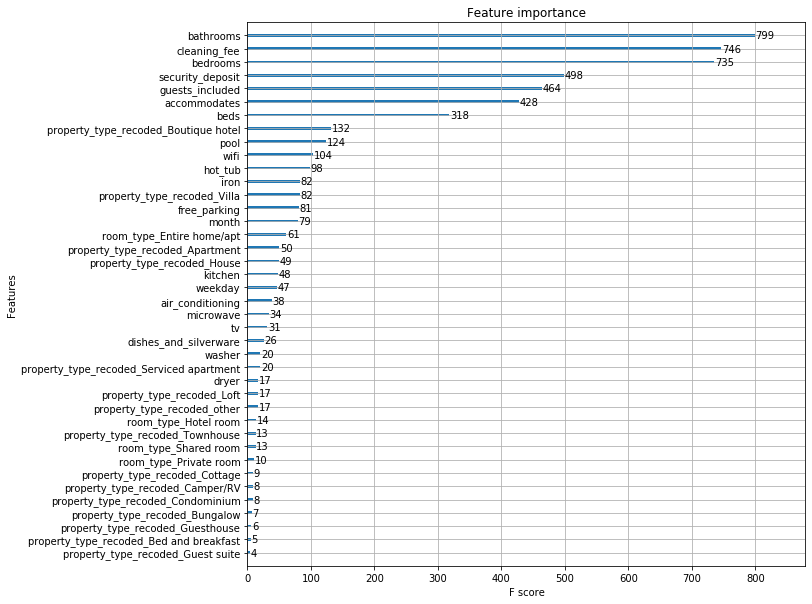

In [13]:
plt.rcParams["figure.figsize"] = (10,10)

xgb.plot_importance(model)

In [15]:
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
rmse

247.37026481414298

In [16]:
test_results = pd.DataFrame(data={'True':y_test, 'Predicted':predictions}, columns= ['True','Predicted'] )
test_results.head()

,True,Predicted
1677792,550.0,329.333435
10701801,110.0,158.864166
8261512,40.0,61.998562
6163719,40.0,42.038132
4911406,200.0,307.916718


In [0]:
test_results.to_csv('predictions.csv', index=False)

In [0]:
# test_results = pd.read_csv('test_predictions.csv')

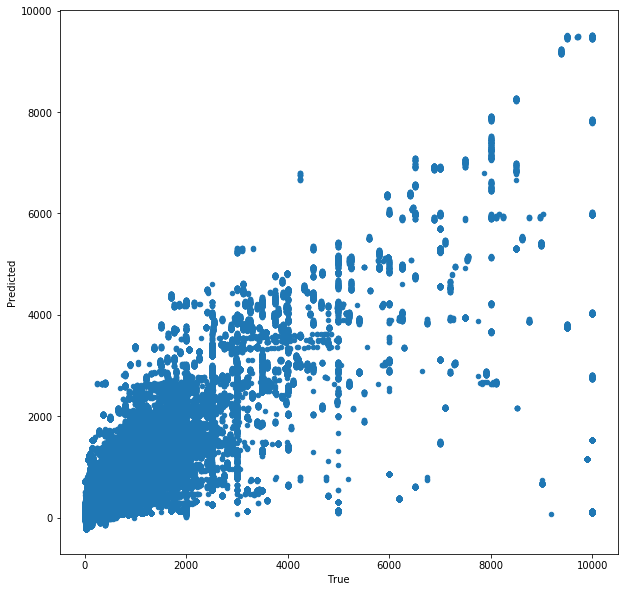

In [17]:
test_results.plot.scatter(x = 'True', y = 'Predicted')

####Save model

In [0]:
# Convert processed data into an xgb.DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [0]:
pickle.dump(model, open("xgbregressor_airbnb_final.dat", "wb"))

In [0]:
model = pickle.load(open("xgbregressor_airbnb_final.dat", "rb"))

NameError: ignored

####Optimize (current model has not been optimized yet)

In [0]:
def xgb_evaluate(colsample_bytree, gamma, learning_rate, max_delta_step, max_depth_step, min_child_weight, n_estimators, subsample):
    params = {'colsample_bytree': colsample_bytree,
              'eta': 0.1,
              'eval_metric': 'rmse',
              'gamma': gamma,
              'learning_rate': learning_rate,
              'max_delta_step': max_delta_step,
              'max_depth_step': int(max_depth_step),
              'min_child_weight': min_child_weight,
              'n_estimators': n_estimators,
              'seed': 9,
              'subsample': subsample}
    # Use around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=1000, nfold=3)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [0]:
xgb_bo = BayesianOptimization(xgb_evaluate, {'colsample_bytree': (0.3, 1),
                                             'gamma': (0, 5),
                                             'learning_rate':(0.01,0.5),
                                             'max_delta_step': (0, 10),
                                             'max_depth_step': (1, 6),
                                             'min_child_weight':(0,5),
                                             'n_estimators':(850, 1200),
                                             'subsample': (0.4, 1.0)})
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=6, n_iter=10, acq='ei')

In [0]:
# Write our ensemble method - train 11 models, and weight them all equally by finding the mode of the votes for each well.
# The majority vote for each well is the consensus, which will be our predictions
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import random

random.seed(42)
count = 0
score = 0
scores = 0
prediction_votes=pd.DataFrame()
for num in range(1,2):
    seed = random.randint(1,9000)
    model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1, 
                          colsample_bynode=1, colsample_bytree=1, gamma=0,
                          importance_type='gain', learning_rate=0.1, max_delta_step=0,
                          max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
                          n_jobs=-1, nthread=None, objective='reg:squarederror', random_state=0,
                          reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                          silent=None, subsample=1, verbosity=1).fit(X_train, y_train)
    predictions = model.predict(X_val)
    #score = accuracy_score(y_val, predictions)
    prediction_votes[num] = predictions
    scores += score
    count += 1
    print(score)
    y_pred_proba = model.predict_proba(X_train)[:,1]
    print('Test ROC AUC:', roc_auc_score(y_train, y_pred_proba))

print(f"The average accuracy score using these hyperparams over {count} iterations is {scores/count}")

d:\csfiles\lambda\git\airbnb3\airenv\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0


AttributeError: 'XGBRegressor' object has no attribute 'predict_proba'